<p>Outliers detector algorithm</p>

In [8]:

import numpy as np
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 200
mxp_df = pd.read_csv("MxpUsedYearActive_ok.csv", sep=',')
categos = pd.read_csv('lista.csv', sep=',')
links =pd.read_csv('Imagenes.csv', sep=',')
csvs = pd.read_csv('EBCcsv', sep=',')
cats = categos.categoryId.sort_values().drop_duplicates().to_list()

       categoryId
0    v_1_10_1_7_1
1    v_1_10_1_7_2
2    v_1_10_7_2_1
3    v_1_10_7_2_2
4    v_1_10_8_4_1
..            ...
266   v_1_8_4_8_1
267  v_1_8_5_14_1
268  v_1_8_9_13_6
269  v_1_9_1_11_1
270  v_1_9_1_11_2

[271 rows x 1 columns]


In [ ]:
for cat in cats:
        mxp_algoritmo_prueba = mxp_df.loc[mxp_df.categoryId == cat.strip(',')]
        mxp_algoritmo_prueba.drop([ 'priceSale',  'pricePurchase'], axis=1, inplace=True)
        mxp_algoritmo_prueba.reset_index(drop=True, inplace=True)
        precios = [[row, index] for (index, row) in mxp_algoritmo_prueba.iterrows()]
        # Se recolectan los registros en un diccionario
        priceFSale = {precio[1]: {'tiempo':precio[0].dateSource,'precio':precio[0].forecastPriceSale} for precio in precios}
        priceFPurchase = {precio[1]: {'tiempo':precio[0].dateSource,'precio':precio[0].forecastPricePurchase} for precio in precios}

        yS = [ [priceFSale[precio]['precio']] for precio in priceFSale]
        yP = [ [priceFPurchase[precio]['precio']] for precio in priceFPurchase]
        mesesSales = [ priceFSale[precio]['tiempo'] for precio in priceFSale]
        mesesPurchase = [ priceFPurchase[precio]['tiempo'] for precio in priceFPurchase]

        # Se separan los valores iniciales y finales
        inicio = mxp_algoritmo_prueba.head(1).index[0]
        final = mxp_algoritmo_prueba.tail(1).index[0]

        #Se separan los valores intermedios
        lista_valores_intermediosSale = mxp_algoritmo_prueba.index.to_list()
        lista_valores_intermediosPurchase = mxp_algoritmo_prueba.index.to_list()

        completosSale = mxp_algoritmo_prueba.index.to_list()
        completosPurchase = mxp_algoritmo_prueba.index.to_list()

        lista_valores_intermediosSale.remove(inicio)
        lista_valores_intermediosSale.remove(final)

        lista_valores_intermediosPurchase.remove(inicio)
        lista_valores_intermediosPurchase.remove(final)

        valores_a_comparar = [row for (index, row) in mxp_algoritmo_prueba.iterrows()]

        mxp_algoritmo_prueba['anomalySales'] = 0
        mxp_algoritmo_prueba['anomalyPurchase'] = 0
        mxp_algoritmo_prueba['factorDeErrorSale'] = 0
        mxp_algoritmo_prueba['factorDeErrorPurchase'] = 0
        mxp_algoritmo_prueba['valorEsperadoSale'] = 0
        mxp_algoritmo_prueba['valorEsperadoPurchase'] = 0
        mxp_algoritmo_prueba['forecastCorregidoSale'] = mxp_algoritmo_prueba['forecastPriceSale']
        mxp_algoritmo_prueba['forecastCorregidoPurchase'] = mxp_algoritmo_prueba['forecastPricePurchase']

        #
        for valor in lista_valores_intermediosSale:
                precio_anterior = valores_a_comparar[(valor-1)]['forecastPriceSale']
                precio_actual = valores_a_comparar[valor]['forecastPriceSale']
                precio_siguiente = valores_a_comparar[(valor+1)]['forecastPriceSale']

                if precio_anterior * 1.015 < precio_actual > precio_siguiente * 1.015\
                        and mxp_algoritmo_prueba.iloc[valor-1]['anomalySales'] != 2 and mxp_algoritmo_prueba.iloc[valor+1]['anomalySales'] != 2:
                        if ((precio_actual/(precio_anterior/100)-100) + (precio_actual/(precio_siguiente/100)-100)) / 2 >= 2:
                                mxp_algoritmo_prueba.at[valor-1, 'anomalySales'] = 3
                                mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 2
                                mxp_algoritmo_prueba.at[valor+1, 'anomalySales'] = 3
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] = ((precio_actual/(precio_anterior/100)-100) + (precio_actual/(precio_siguiente/100)-100)) / 2
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoSale'] = (precio_anterior + precio_siguiente)/2
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoSale'] = mxp_algoritmo_prueba.iloc[valor]['valorEsperadoSale']


                elif precio_anterior * 0.985 > precio_actual < precio_siguiente * 0.985\
                        and mxp_algoritmo_prueba.iloc[valor-1]['anomalySales'] != 2 and mxp_algoritmo_prueba.iloc[valor+1]['anomalySales'] != 2:
                        if ((-(100-precio_actual/(precio_anterior/100))) + (-(100-precio_actual/(precio_siguiente/100)))) / 2 <= -2:
                                mxp_algoritmo_prueba.at[valor-1, 'anomalySales'] = 3
                                mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 2
                                mxp_algoritmo_prueba.at[valor+1, 'anomalySales'] = 3
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] = ((-(100-precio_actual/(precio_anterior/100))) + (-(100-precio_actual/(precio_siguiente/100)))) / 2
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoSale'] = (precio_anterior + precio_siguiente)/2
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoSale'] = mxp_algoritmo_prueba.iloc[valor]['valorEsperadoSale']

        sube=False
        baja=False
        inicio_final_sale = []
        escalon = 0
        desnivel = 0
        for valor in completosSale:
                if valor < completosSale[-2] and (mxp_algoritmo_prueba.iloc[valor]['anomalySales'] != 3 and mxp_algoritmo_prueba.iloc[valor]['anomalySales'] != 2):
                        precio_actual = valores_a_comparar[valor]['forecastPriceSale']
                        precio_siguiente = valores_a_comparar[(valor+1)]['forecastPriceSale']
                        precio_siguiente2 = valores_a_comparar[(valor+2)]['forecastPriceSale']

                        if  (precio_actual/(precio_siguiente/100)-100) >= 6.2:
                                baja = True
                                inicio_final_sale.append(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'])
                                inicio_final_sale.append(mxp_algoritmo_prueba.iloc[valor+1]['forecastPriceSale'])
                                if desnivel == 0:
                                        desnivel = valor
                                escalon = valor + 1
                                mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 1
                                mxp_algoritmo_prueba.at[valor+1, 'anomalySales'] = 1
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] =  (precio_actual/(precio_siguiente/100))-100

                        elif (precio_actual/(precio_siguiente/100)-100) <= -6.2:
                                sube = True
                                inicio_final_sale.append(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'])
                                inicio_final_sale.append(mxp_algoritmo_prueba.iloc[valor+1]['forecastPriceSale'])
                                if desnivel == 0:
                                        desnivel = valor
                                escalon = valor + 1
                                mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 1
                                mxp_algoritmo_prueba.at[valor+1, 'anomalySales'] = 1
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] = (precio_actual/(precio_siguiente/100))-100

        if sube and baja:
                for valor in completosSale[desnivel+1:escalon]:
                        if mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'] in inicio_final_sale:
                                        mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 1
                                        mxp_algoritmo_prueba.at[valor, 'valorEsperadoSale'] = (inicio_final_sale[0] + inicio_final_sale[-1])/2
                                        mxp_algoritmo_prueba.at[valor, 'forecastCorregidoSale'] = (inicio_final_sale[0] + inicio_final_sale[-1])/2

        else:
                if sube or baja:
                        for valor in completosSale[desnivel:escalon+1]:

                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] = (mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale']/(mxp_algoritmo_prueba.iloc[escalon]['forecastPriceSale']/100))-100
                                diferencia = mxp_algoritmo_prueba.iloc[escalon]['forecastPriceSale'] - mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale']
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoSale'] =np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'] + diferencia)
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoSale'] = np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'] + diferencia)

                        for valor in completosSale[:desnivel]:
                                mxp_algoritmo_prueba.at[valor, 'anomalySales'] = 4
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorSale'] = (mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale']/(mxp_algoritmo_prueba.iloc[escalon]['forecastPriceSale']/100))-100
                                diferencia = mxp_algoritmo_prueba.iloc[escalon]['forecastPriceSale'] - mxp_algoritmo_prueba.iloc[desnivel]['forecastPriceSale']
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoSale'] =np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'] + diferencia)
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoSale'] = np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPriceSale'] + diferencia)


        for valor in lista_valores_intermediosPurchase:
                precio_anterior = valores_a_comparar[(valor-1)]['forecastPricePurchase']
                precio_actual = valores_a_comparar[valor]['forecastPricePurchase']
                precio_siguiente = valores_a_comparar[(valor+1)]['forecastPricePurchase']

                if precio_anterior * 1.013 < precio_actual > precio_siguiente * 1.013\
                        and mxp_algoritmo_prueba.iloc[valor-1]['anomalyPurchase']!=3 and mxp_algoritmo_prueba.iloc[valor+1]['anomalyPurchase']!=3:
                        if ((precio_actual/(precio_anterior/100)-100) + (precio_actual/(precio_siguiente/100)-100)) / 2 >= 2:
                                mxp_algoritmo_prueba.at[valor-1, 'anomalyPurchase'] = 3
                                mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 2
                                mxp_algoritmo_prueba.at[valor+1, 'anomalyPurchase'] = 3
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = ((precio_actual/(precio_anterior/100)-100)  +  (precio_actual/(precio_siguiente/100))-100) / 2
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoPurchase'] = (precio_anterior + precio_siguiente)/2
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoPurchase'] = mxp_algoritmo_prueba.iloc[valor]['valorEsperadoPurchase']

                elif precio_anterior * 0.987 > precio_actual < precio_siguiente * 0.987\
                        and mxp_algoritmo_prueba.iloc[valor-1]['anomalyPurchase']!=3 and mxp_algoritmo_prueba.iloc[valor+1]['anomalyPurchase']!=3:
                        if ((-(100-precio_actual/(precio_anterior/100))) + (-(100-precio_actual/(precio_siguiente/100)))) / 2 <= -2:
                                mxp_algoritmo_prueba.at[valor-1, 'anomalyPurchase'] = 3
                                mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 2
                                mxp_algoritmo_prueba.at[valor+1, 'anomalyPurchase'] = 3
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = ((-(100-precio_actual/(precio_anterior/100))) + (-(100-precio_actual/(precio_siguiente/100)))) / 2
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoPurchase'] = (precio_anterior + precio_siguiente)/2
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoPurchase'] = mxp_algoritmo_prueba.iloc[valor]['valorEsperadoPurchase']


        sube=False
        baja=False
        inicio_final_purchase = []
        escalon = 0
        desnivel = 0
        for valor in completosPurchase:
                if valor < completosPurchase[-2] and (mxp_algoritmo_prueba.iloc[valor]['anomalyPurchase'] != 3 and mxp_algoritmo_prueba.iloc[valor]['anomalyPurchase'] != 2):
                        precio_actual = valores_a_comparar[valor]['forecastPricePurchase']
                        precio_siguiente = valores_a_comparar[(valor+1)]['forecastPricePurchase']
                        precio_siguiente2 = valores_a_comparar[(valor+1)]['forecastPricePurchase']

                        if (precio_actual/(precio_siguiente/100)-100) >= 6.2:
                                baja=True
                                inicio_final_purchase.append(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'])
                                inicio_final_purchase.append(mxp_algoritmo_prueba.iloc[valor+1]['forecastPricePurchase'])
                                if desnivel == 0:
                                        desnivel = valor
                                escalon = valor + 1
                                mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 1
                                mxp_algoritmo_prueba.at[valor+1, 'anomalyPurchase'] = 1
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = (precio_actual/(precio_siguiente/100))-100

                        elif (precio_actual/(precio_siguiente/100)-100) <= -6.2:
                                sube = True
                                inicio_final_purchase.append(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'])
                                inicio_final_purchase.append(mxp_algoritmo_prueba.iloc[valor+1]['forecastPricePurchase'])
                                if desnivel == 0:
                                        desnivel = valor
                                escalon = valor + 1
                                mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 1
                                mxp_algoritmo_prueba.at[valor+1, 'anomalyPurchase'] = 1
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = (precio_actual/(precio_siguiente/100))-100

        if sube and baja:
                for valor in completosPurchase[desnivel+1:escalon]:
                        if mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'] in inicio_final_purchase:
                                        mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 1
                                        mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = (mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase']/(mxp_algoritmo_prueba.iloc[escalon]['forecastPricePurchase']/100))-100
                                        mxp_algoritmo_prueba.at[valor, 'valorEsperadoPurchase'] = (inicio_final_purchase[0] + inicio_final_purchase[-1])/2
                                        mxp_algoritmo_prueba.at[valor, 'forecastCorregidoPurchase'] = (inicio_final_purchase[0] + inicio_final_purchase[-1])/2
        else:
                if sube or baja:
                        for valor in completosPurchase[desnivel:escalon+1]:
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = (mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase']/(mxp_algoritmo_prueba.iloc[escalon]['forecastPricePurchase']/100))-100
                                diferencia = mxp_algoritmo_prueba.iloc[escalon]['forecastPricePurchase'] - mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase']
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoPurchase'] = np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'] + diferencia)
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoPurchase'] = np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'] + diferencia)

                        for valor in completosPurchase[:desnivel]:
                                mxp_algoritmo_prueba.at[valor, 'anomalyPurchase'] = 4
                                mxp_algoritmo_prueba.at[valor, 'factorDeErrorPurchase'] = (mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase']/(mxp_algoritmo_prueba.iloc[escalon]['forecastPricePurchase']/100))-100
                                diferencia = mxp_algoritmo_prueba.iloc[escalon]['forecastPricePurchase'] - mxp_algoritmo_prueba.iloc[desnivel]['forecastPricePurchase']
                                mxp_algoritmo_prueba.at[valor, 'valorEsperadoPurchase'] =np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'] + diferencia)
                                mxp_algoritmo_prueba.at[valor, 'forecastCorregidoPurchase'] = np.int64(mxp_algoritmo_prueba.iloc[valor]['forecastPricePurchase'] + diferencia)


        is_anomaly_purchase = 1 in mxp_algoritmo_prueba['anomalyPurchase'].values or 2 in mxp_algoritmo_prueba['anomalyPurchase'].values
        is_anomaly_sale = 1 in mxp_algoritmo_prueba['anomalySales'].values or 2 in mxp_algoritmo_prueba['anomalySales'].values
        categ = mxp_algoritmo_prueba.iloc[0]['categoryId']


        # #--------------------------------------------------------------------------------------------
        if is_anomaly_purchase or is_anomaly_sale:
                anomaliasS = [[row['dateSource'], row['factorDeErrorSale'], row['forecastPriceSale'], row['valorEsperadoSale'] ] for (index, row) in mxp_algoritmo_prueba.iterrows() if row['anomalySales'] == 1 or row['anomalySales'] == 2 or row['anomalySales'] == 4]
                anomaliasP = [[row['dateSource'], row['factorDeErrorPurchase'], row['forecastPricePurchase'], row['valorEsperadoPurchase'] ] for (index, row) in mxp_algoritmo_prueba.iterrows() if row['anomalyPurchase'] == 1 or row['anomalyPurchase'] == 2 or row['anomalyPurchase'] == 4]

                with open('/Users/Artema/Desktop/deteccionesEbcUsed.txt', 'a') as repo:
                        if os.stat('/Users/Artema/Desktop/deteccionesEbcUsed.txt').st_size == 0:
                                repo.write('categoryId,' + 'periodo,' + 'tipoDePrecio,' + 'factorDeError%,' + 'valor,' + 'valorEsperado,' + 'imagen,' +'csv'+ '\n')
                        index = links.loc[links['Name'] == categ + '.jpg'].index
                        cs_index = csvs.loc[csvs['Name'] == categ + '.csv'].index
                        link = str(links.iloc[index]['URL']).split(' ')[4].strip('\nName:')
                        csv = str(csvs.iloc[cs_index]['URL']).split(' ')[4].strip('\nName:')
                        l = 0
                        for anoma in anomaliasS:
                                if l == 0:
                                        repo.write(categ + ',' + f'{anoma[0]},' + 'venta,' +f'{round(anoma[1], 2)},'+ f'{anoma[2]},'+ f'{anoma[3]},' + f'{link},' + f'{csv}' + '\n')
                                else:
                                        repo.write(categ + ',' + f'{anoma[0]},' + 'venta,' + f'{round(anoma[1], 2)},' + f'{anoma[2]},' + f'{anoma[3]}' +'\n')
                                l = 1
                        for anoma in anomaliasP:
                                if l == 0:
                                        repo.write(categ + ',' + f'{anoma[0]},' + 'compra,' + f'{round(anoma[1], 2)},' + f'{anoma[2]},' + f'{anoma[3]},' + f'{link},' + f'{csv}' +'\n')
                                else:
                                        repo.write(categ + ',' + f'{anoma[0]},' + 'compra,' + f'{round(anoma[1], 2)},' + f'{anoma[2]},' + f'{anoma[3]}' +'\n')
                                l = 1
                repo.close()


print('Reporte con links generado')


<p>Examples of detected outliers, corrected and flagged</p>

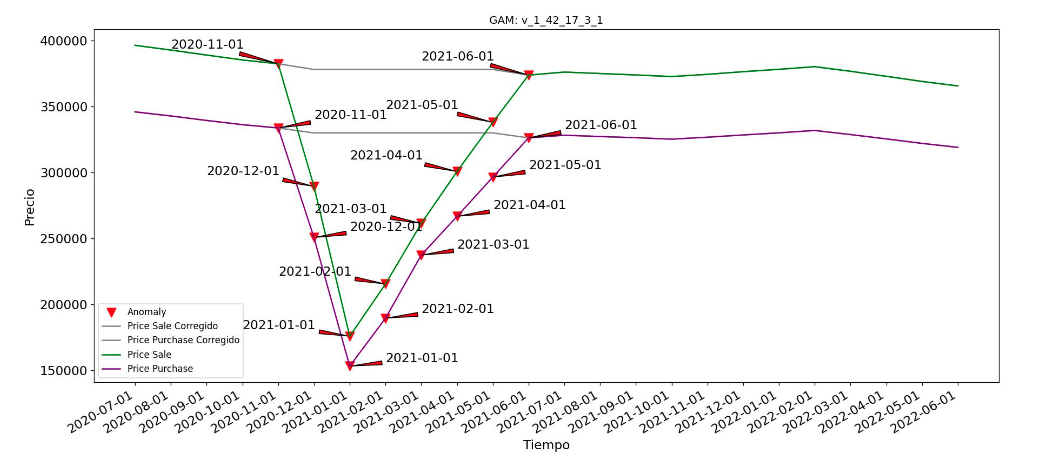

In [3]:
from IPython.display import Image
Image(filename='second_example.png',width=800, height=400)

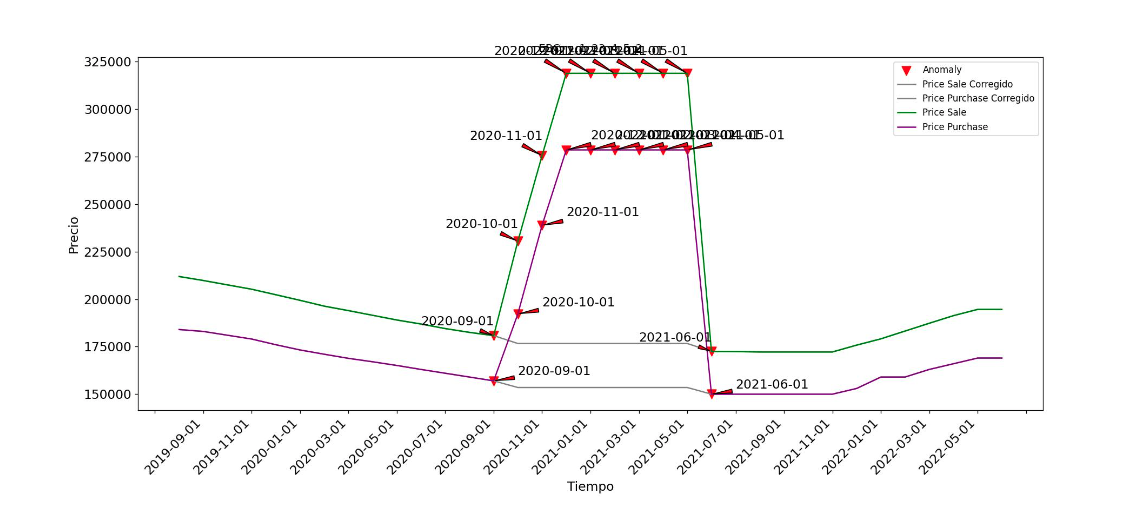

In [4]:
Image(filename='example.png',width=800, height=400)


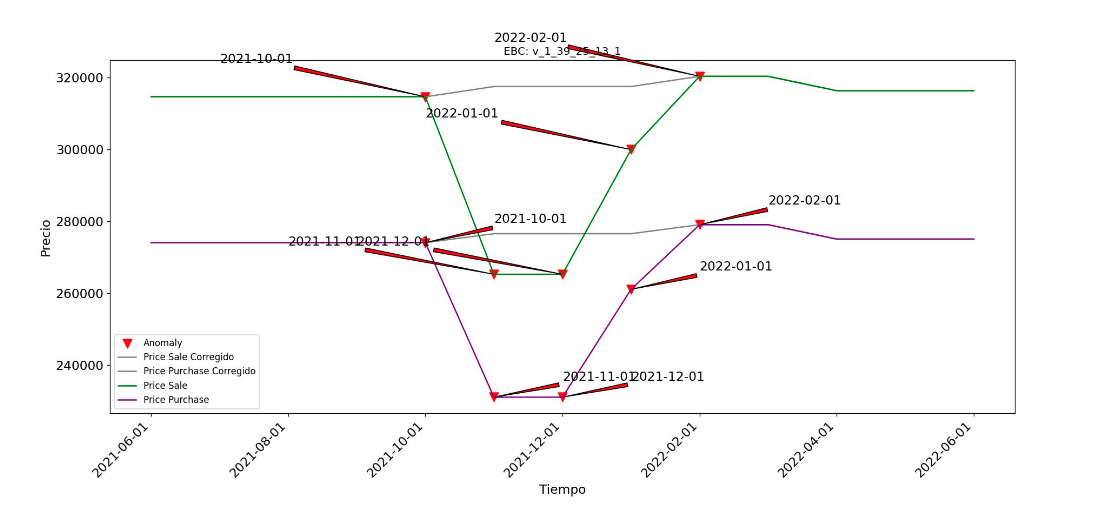

In [5]:
Image(filename='example_3.png',width=800, height=400)


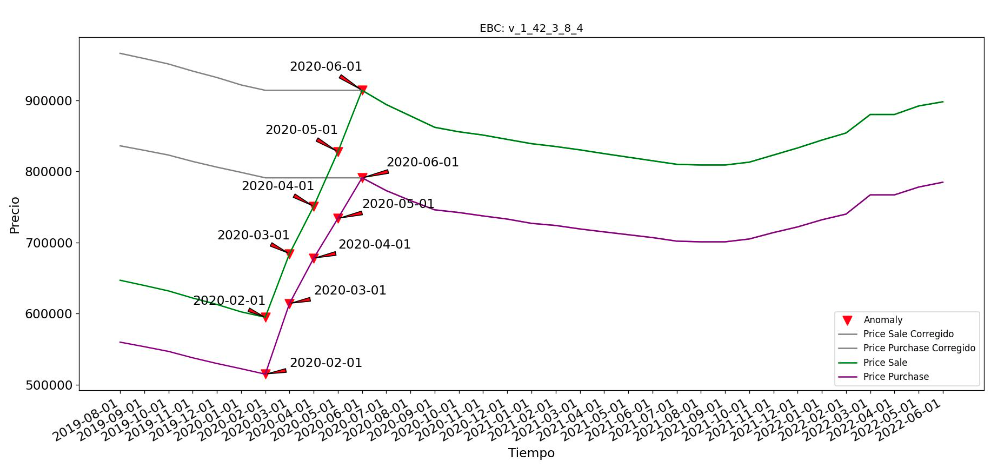

In [7]:
Image(filename='example_4.png',width=800, height=400)
